In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os
from cyvcf2 import VCF
from tqdm import tqdm
from functools import partial
from scipy.sparse import csr_matrix

# Create the predicted score files

Can be skipped: go to analysis

In [33]:
eqtl = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_patients.csv')

In [34]:
eqtl.head()

,Unnamed: 0,Cell type,Gene ID,Gene Ensembl ID,SNP,Chromosome,Position,SNP assessed allele,eSNP rank,rho correlation coefficient,S-statistics,pvalue,qvalue,FDR,ref_samples,hom_ref_samples,het_samples,hom_alt_samples
0,0,B IN,RP11-298J20.3,ENSG00000226899,rs4962711,10,126644482,C,eSNP1,-0.473,2.324188e+08,8.650000e-56,5.110000e-50,0.000022,0,"12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_...","8_8,23_23,24_24,27_27,28_28,30_30,32_32,33_33,...","1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,13_13,..."
1,1,B IN,PPA1,ENSG00000180817,rs12355080,10,71963608,A,eSNP1,0.428,9.033813e+07,6.310000e-45,1.650000e-40,0.000022,0,"1_1,4_4,7_7,8_8,10_10,15_15,17_17,18_18,21_21,...","3_3,6_6,11_11,12_12,13_13,16_16,19_19,20_20,23...","2_2,9_9,14_14,25_25,34_34,36_36,47_47,57_57,68..."
2,2,B IN,GDI2,ENSG00000057608,rs3736461,10,5855403,C,eSNP1,-0.278,2.017159e+08,6.760000e-19,6.080000e-15,0.000022,0,"1_1,3_3,4_4,7_7,8_8,9_9,12_12,13_13,14_14,18_1...","2_2,10_10,11_11,15_15,16_16,17_17,21_21,28_28,...","6_6,27_27,36_36,45_45,61_61,78_78,242_243,263_..."
3,3,B IN,OPTN,ENSG00000123240,rs57057378,10,13160035,A,eSNP1,-0.258,1.984947e+08,2.340000e-16,2.030000e-12,0.000022,0,"2_2,3_3,4_4,6_6,10_10,12_12,13_13,14_14,18_18,...","1_1,9_9,11_11,15_15,16_16,17_17,20_20,26_26,27...","7_7,8_8,21_21,23_23,25_25,34_34,35_35,39_39,40..."
4,4,B IN,MGMT,ENSG00000170430,rs12254582,10,131279791,G,eSNP1,-0.220,1.925261e+08,3.260000e-12,2.150000e-08,0.000022,0,"6_6,8_8,9_9,10_10,11_11,14_14,15_15,16_16,17_1...","1_1,2_2,4_4,21_21,26_26,29_29,32_32,35_35,38_3...","3_3,7_7,12_12,13_13,28_28,33_33,44_44,56_56,62..."


In [35]:
eqtl=eqtl.rename(columns={'rho correlation coefficient':'rho'})

In [38]:
eqtl['all_snp'] = eqtl.groupby(['Gene Ensembl ID', 'Cell type'])['SNP'].transform(lambda x: ','.join(x))

In [49]:
eqtl = eqtl.loc[:, ['Gene ID', 'Gene Ensembl ID', 'Cell type', 'SNP', 'all_snp', 'rho', 'hom_ref_samples', 'hom_alt_samples', 'het_samples']]
eqtl = eqtl.fillna('none')

In [50]:
eqtl.head()

,Gene ID,Gene Ensembl ID,Cell type,SNP,all_snp,rho,hom_ref_samples,hom_alt_samples,het_samples
0,RP11-298J20.3,ENSG00000226899,B IN,rs4962711,"rs4962711,rs77741718,rs76509216,rs77111523,rs9...",-0.473,"12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_...","1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,13_13,...","8_8,23_23,24_24,27_27,28_28,30_30,32_32,33_33,..."
1,PPA1,ENSG00000180817,B IN,rs12355080,rs12355080,0.428,"1_1,4_4,7_7,8_8,10_10,15_15,17_17,18_18,21_21,...","2_2,9_9,14_14,25_25,34_34,36_36,47_47,57_57,68...","3_3,6_6,11_11,12_12,13_13,16_16,19_19,20_20,23..."
2,GDI2,ENSG00000057608,B IN,rs3736461,rs3736461,-0.278,"1_1,3_3,4_4,7_7,8_8,9_9,12_12,13_13,14_14,18_1...","6_6,27_27,36_36,45_45,61_61,78_78,242_243,263_...","2_2,10_10,11_11,15_15,16_16,17_17,21_21,28_28,..."
3,OPTN,ENSG00000123240,B IN,rs57057378,rs57057378,-0.258,"2_2,3_3,4_4,6_6,10_10,12_12,13_13,14_14,18_18,...","7_7,8_8,21_21,23_23,25_25,34_34,35_35,39_39,40...","1_1,9_9,11_11,15_15,16_16,17_17,20_20,26_26,27..."
4,MGMT,ENSG00000170430,B IN,rs12254582,rs12254582,-0.220,"6_6,8_8,9_9,10_10,11_11,14_14,15_15,16_16,17_1...","3_3,7_7,12_12,13_13,28_28,33_33,44_44,56_56,62...","1_1,2_2,4_4,21_21,26_26,29_29,32_32,35_35,38_3..."


In [35]:
# Load just to get the names of all the samples
folder = '/omics/groups/OE0540/internal/users/senacheribbe/work/rarevar/data/onek1k/genotype/filter_vcf_r08/'
fname = 'chr1.dose.filtered.R2_0.8.vcf.gz'
vcf_file = VCF(os.path.join(folder,fname))
samples = np.array(vcf_file.samples)

In [54]:
eqtl[samples] = 0

In [55]:
eqtl.head()

,Gene ID,Gene Ensembl ID,Cell type,SNP,all_snp,rho,hom_ref_samples,hom_alt_samples,het_samples,1_1,...,1079_1080,1080_1081,1081_1082,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2
0,RP11-298J20.3,ENSG00000226899,B IN,rs4962711,"rs4962711,rs77741718,rs76509216,rs77111523,rs9...",-0.473,"12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_...","1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,13_13,...","8_8,23_23,24_24,27_27,28_28,30_30,32_32,33_33,...",0,...,0,0,0,0,0,0,0,0,0,0
1,PPA1,ENSG00000180817,B IN,rs12355080,rs12355080,0.428,"1_1,4_4,7_7,8_8,10_10,15_15,17_17,18_18,21_21,...","2_2,9_9,14_14,25_25,34_34,36_36,47_47,57_57,68...","3_3,6_6,11_11,12_12,13_13,16_16,19_19,20_20,23...",0,...,0,0,0,0,0,0,0,0,0,0
2,GDI2,ENSG00000057608,B IN,rs3736461,rs3736461,-0.278,"1_1,3_3,4_4,7_7,8_8,9_9,12_12,13_13,14_14,18_1...","6_6,27_27,36_36,45_45,61_61,78_78,242_243,263_...","2_2,10_10,11_11,15_15,16_16,17_17,21_21,28_28,...",0,...,0,0,0,0,0,0,0,0,0,0
3,OPTN,ENSG00000123240,B IN,rs57057378,rs57057378,-0.258,"2_2,3_3,4_4,6_6,10_10,12_12,13_13,14_14,18_18,...","7_7,8_8,21_21,23_23,25_25,34_34,35_35,39_39,40...","1_1,9_9,11_11,15_15,16_16,17_17,20_20,26_26,27...",0,...,0,0,0,0,0,0,0,0,0,0
4,MGMT,ENSG00000170430,B IN,rs12254582,rs12254582,-0.220,"6_6,8_8,9_9,10_10,11_11,14_14,15_15,16_16,17_1...","3_3,7_7,12_12,13_13,28_28,33_33,44_44,56_56,62...","1_1,2_2,4_4,21_21,26_26,29_29,32_32,35_35,38_3...",0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
eqtl.loc[0, 'hom_ref_samples']

'12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_103,108_108,137_137,158_158,160_160,161_161,175_176,191_192,220_221,222_223,229_230,261_262,272_273,284_285,305_306,338_339,348_349,356_357,392_393,402_403,411_412,415_416,429_430,478_479,486_487,491_492,496_497,505_506,519_520,532_533,543_544,550_551,593_594,594_595,596_597,607_608,623_624,651_652,653_654,680_681,688_689,743_744,746_747,771_772,789_790,791_792,798_799,813_814,820_821,823_824,826_827,835_836,853_854,870_871,884_885,893_894,895_896,912_913,927_928,932_933,979_980,1001_1002,1005_1006,1009_1010,1041_1042,1042_1043,1051_1052,1055_1056,1077_1078'

In [ ]:
# For each SNP and each individual set the score to 1 if hom_alt, to 0.5 if het and to 0 if hom_ref
for individual in tqdm(samples):
    search_str = '(?:^|,)' + individual + '(?:,|$)'
    mask_hom_alt = eqtl.hom_alt_samples.str.contains(search_str, regex=True)
    mask_het = eqtl.het_samples.str.contains(search_str, regex=True)
    eqtl.loc[:, individual][mask_hom_alt] = 1 * eqtl.loc[:, 'rho'][mask_hom_alt]
    eqtl.loc[:, individual][mask_het] = 0.5 * eqtl.loc[:, 'rho'][mask_het]

 28%|██▊       | 293/1034 [07:59<22:44,  1.84s/it]/tmp/ipykernel_16663/1779499927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl.loc[:, individual][mask_hom_alt] = 1 * eqtl.loc[:, 'rho'][mask_hom_alt]
 75%|███████▍  | 775/1034 [24:25<10:24,  2.41s/it]

In [9]:
# get the most extreme possible score
eqtl['extreme_score'] = eqtl['rho']

In [10]:
eqtl.head()

,Gene ID,Gene Ensembl ID,Cell type,SNP,all_snp,rho,hom_ref_samples,hom_alt_samples,het_samples,1_1,...,1080_1081,1081_1082,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score
0,RP11-298J20.3,ENSG00000226899,B IN,rs4962711,"rs4962711,rs77741718,rs76509216,rs77111523,rs9...",-0.473,"12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_...","1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,13_13,...","8_8,23_23,24_24,27_27,28_28,30_30,32_32,33_33,...",-0.473,...,-0.473,-0.473,-0.2365,-0.473,-0.473,-0.473,-0.473,-0.2365,-0.473,-0.473
1,PPA1,ENSG00000180817,B IN,rs12355080,rs12355080,0.428,"1_1,4_4,7_7,8_8,10_10,15_15,17_17,18_18,21_21,...","2_2,9_9,14_14,25_25,34_34,36_36,47_47,57_57,68...","3_3,6_6,11_11,12_12,13_13,16_16,19_19,20_20,23...",0.000,...,0.214,0.000,0.2140,0.214,0.214,0.214,0.000,0.0000,0.214,0.428
2,GDI2,ENSG00000057608,B IN,rs3736461,rs3736461,-0.278,"1_1,3_3,4_4,7_7,8_8,9_9,12_12,13_13,14_14,18_1...","6_6,27_27,36_36,45_45,61_61,78_78,242_243,263_...","2_2,10_10,11_11,15_15,16_16,17_17,21_21,28_28,...",0.000,...,0.000,-0.139,0.0000,0.000,0.000,0.000,0.000,-0.1390,-0.139,-0.278
3,OPTN,ENSG00000123240,B IN,rs57057378,rs57057378,-0.258,"2_2,3_3,4_4,6_6,10_10,12_12,13_13,14_14,18_18,...","7_7,8_8,21_21,23_23,25_25,34_34,35_35,39_39,40...","1_1,9_9,11_11,15_15,16_16,17_17,20_20,26_26,27...",-0.129,...,-0.129,0.000,0.0000,0.000,0.000,0.000,-0.129,0.0000,0.000,-0.258
4,MGMT,ENSG00000170430,B IN,rs12254582,rs12254582,-0.220,"6_6,8_8,9_9,10_10,11_11,14_14,15_15,16_16,17_1...","3_3,7_7,12_12,13_13,28_28,33_33,44_44,56_56,62...","1_1,2_2,4_4,21_21,26_26,29_29,32_32,35_35,38_3...",-0.110,...,-0.110,0.000,0.0000,0.000,-0.220,-0.110,0.000,0.0000,-0.110,-0.220


In [8]:
eqtl = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_cummulative_intermediate.csv', index_col=0)

In [17]:
column_names = np.concatenate([samples, np.array(['extreme_score'])])
eqtl_group = eqtl.groupby(['Gene Ensembl ID', 'Gene ID', 'Cell type', 'all_snp'])[column_names].sum()
eqtl_group.head()

1_1  \
Gene Ensembl ID Gene ID Cell type all_snp                                                
ENSG00000001167 NFYA    CD4 NC    rs6912359                                    -0.0720   
                        CD8 S100B rs61372030                                    0.0000   
ENSG00000001461 NIPAL3  NK        rs61774838                                    0.0000   
ENSG00000001561 ENPP4   CD8 ET    rs7769738                                     0.0675   
                        DC        rs475991,rs538242,rs514240,rs513394,rs484874  1.0640   

                                                                                   2_2  \
Gene Ensembl ID Gene ID Cell type all_snp                                                
ENSG00000001167 NFYA    CD4 NC    rs6912359                                     0.0000   
                        CD8 S100B rs61372030                                    0.0000   
ENSG00000001461 NIPAL3  NK        rs61774838                                    0.0000   
ENSG00000001561 ENPP4   CD8 ET    rs7769738                                     0.0675   
                        DC        rs475991,rs538242,rs514240,rs513394,rs484874  1.0640   

                                                                                   3_3  \
Gene Ensembl ID Gene ID Cell type all_snp                                                
ENSG00000001167 NFYA    CD4 NC    rs6912359                                     0.0000   
                        CD8 S100B rs61372030                                    0.0000   
ENSG00000001461 NIPAL3  NK        rs61774838                                    0.0765   
ENSG00000001561 ENPP4   CD8 ET    rs7769738                                     0.1350   
                        DC        rs475991,rs538242,rs514240,rs513394,rs484874  1.0640   

                                                                                  4_4  \
Gene Ensembl ID Gene ID Cell type all_snp                                               
ENSG00000001167 NFYA    CD4 NC    rs6912359                                     0.000   
                        CD8 S100B rs61372030                                   -0.065   
ENSG00000001461 NIPAL3  NK        rs61774838                                    0.000   
ENSG00000001561 ENPP4   CD8 ET    rs7769738                                     0.135   
                        DC        rs475991,rs538242,rs514240,rs513394,rs484874  1.064   

                                                                                  6_6  \
Gene Ensembl ID Gene ID Cell type all_snp                                               
ENSG00000001167 NFYA    CD4 NC    rs6912359                                     0.000   
                        CD8 S100B rs61372030                                   -0.065   
ENSG00000001461 NIPAL3  NK        rs61774838                                    0.000   
ENSG00000001561 ENPP4   CD8 ET    rs7769738                                     0.135   
                        DC        rs475991,rs538242,rs514240,rs513394,rs484874  1.064   

                                                                                  7_7  \
Gene Ensembl ID Gene ID Cell type all_snp                                               
ENSG00000001167 NFYA    CD4 NC    rs6912359                                     0.000   
                        CD8 S100B rs61372030                                   -0.130   
ENSG00000001461 NIPAL3  NK        rs61774838                                    0.000   
ENSG00000001561 ENPP4   CD8 ET    rs7769738                                     0.135   
                        DC        rs475991,rs538242,rs514240,rs513394,rs484874  1.064   

                                                                                   8_8  \
Gene Ensembl ID Gene ID Cell type all_snp                                                
ENSG00000001167 NFYA    CD4 NC    rs6912359                                     0.0000   
                        CD8 S100B rs61372030    

In [18]:
eqtl_group = eqtl_group.reset_index()

In [19]:
eqtl_group.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1080_1081,1081_1082,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score
0,ENSG00000001167,NFYA,CD4 NC,rs6912359,-0.0720,0.0000,0.0000,0.000,0.000,0.000,...,-0.072,0.0000,0.0000,0.000,-0.0720,-0.072,-0.0720,-0.0720,0.0000,-0.144
1,ENSG00000001167,NFYA,CD8 S100B,rs61372030,0.0000,0.0000,0.0000,-0.065,-0.065,-0.130,...,0.000,0.0000,0.0000,-0.065,-0.0650,-0.130,-0.0650,-0.1300,-0.0650,-0.130
2,ENSG00000001461,NIPAL3,NK,rs61774838,0.0000,0.0000,0.0765,0.000,0.000,0.000,...,0.000,0.0000,0.0000,0.000,0.0000,0.000,0.0765,0.0765,0.0000,0.153
3,ENSG00000001561,ENPP4,CD8 ET,rs7769738,0.0675,0.0675,0.1350,0.135,0.135,0.135,...,0.135,0.0675,0.0675,0.135,0.0675,0.000,0.0675,0.0000,0.0675,0.135
4,ENSG00000001561,ENPP4,DC,"rs475991,rs538242,rs514240,rs513394,rs484874",1.0640,1.0640,1.0640,1.064,1.064,1.064,...,1.064,1.0640,1.0640,0.532,1.0640,1.064,0.5320,1.0640,1.0640,1.064


#### Controlling for same number of genes and gene ids

In [112]:
np.unique(eqtl_group['Gene Ensembl ID']).shape

(6469,)

In [113]:
np.unique(eqtl_group['Gene ID']).shape

(6468,)

In [117]:
np.where(eqtl_group.duplicated(subset=['Gene ID']))

(array([1561]),)

In [118]:
eqtl_group.iloc[1561, :]

Gene Ensembl ID         ENSG00000117791
Gene ID                          Mar-02
all_snp            rs6697965,rs11118600
1_1                                 1.0
2_2                                 0.0
                           ...         
1096_845_2                          1.0
1100_914_2                          1.0
1102_932_2                          0.0
1103_926_2                          1.0
1104_920_2                          0.0
Name: 1561, Length: 1037, dtype: object

In [119]:
eqtl_group[eqtl_group['Gene ID']=='Mar-02']

,Gene Ensembl ID,Gene ID,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,8_8,...,1079_1080,1080_1081,1081_1082,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2
693,ENSG00000099785,Mar-02,"rs12150986,rs2913973,rs12150986,rs890849",3.0,2.0,3.0,3.0,2.0,3.0,3.0,...,2.0,2.0,3.0,2.0,1.0,2.0,2.0,3.0,2.0,2.0
1561,ENSG00000117791,Mar-02,"rs6697965,rs11118600",1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Conclusion: two different genes, actually the most used names nowdays are also different

#### Continuation

In [20]:
eqtl_group['n_snp'] = eqtl_group.all_snp.str.count(',') +1

In [21]:
eqtl_group['var'] = eqtl_group.iloc[:, 4:-2].var(axis=1, skipna=True)

In [22]:
eqtl_group.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score,n_snp,var
0,ENSG00000001167,NFYA,CD4 NC,rs6912359,-0.0720,0.0000,0.0000,0.000,0.000,0.000,...,0.0000,0.000,-0.0720,-0.072,-0.0720,-0.0720,0.0000,-0.144,1,0.001024
1,ENSG00000001167,NFYA,CD8 S100B,rs61372030,0.0000,0.0000,0.0000,-0.065,-0.065,-0.130,...,0.0000,-0.065,-0.0650,-0.130,-0.0650,-0.1300,-0.0650,-0.130,1,0.001563
2,ENSG00000001461,NIPAL3,NK,rs61774838,0.0000,0.0000,0.0765,0.000,0.000,0.000,...,0.0000,0.000,0.0000,0.000,0.0765,0.0765,0.0000,0.153,1,0.001192
3,ENSG00000001561,ENPP4,CD8 ET,rs7769738,0.0675,0.0675,0.1350,0.135,0.135,0.135,...,0.0675,0.135,0.0675,0.000,0.0675,0.0000,0.0675,0.135,1,0.002212
4,ENSG00000001561,ENPP4,DC,"rs475991,rs538242,rs514240,rs513394,rs484874",1.0640,1.0640,1.0640,1.064,1.064,1.064,...,1.0640,0.532,1.0640,1.064,0.5320,1.0640,1.0640,1.064,5,0.034919


In [23]:
eqtl_group.to_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_cummulative.csv')

# Analysis

Load cummulative eQTL data

In [3]:
eqtl_group = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_cummulative.csv', index_col=0)

## Cumulative effect size distribution

In [9]:
np.unique(eqtl_group.n_snp, return_counts=True)

(array([1, 2, 3, 4, 5]), array([11860,  2508,   595,   234,  1400]))

<Axes: ylabel='n_snp'>

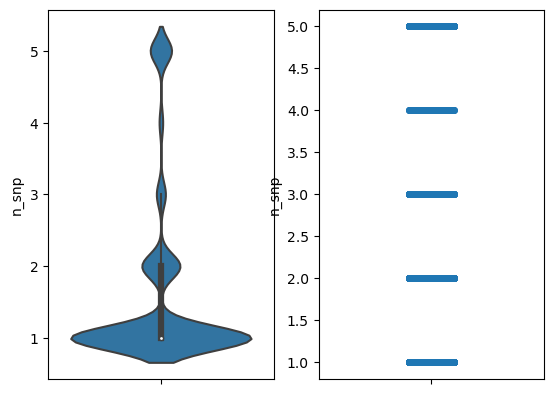

In [10]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(eqtl_group, y='n_snp', ax= ax[0])
sns.stripplot(eqtl_group, y='n_snp', ax= ax[1])

<Axes: ylabel='var'>

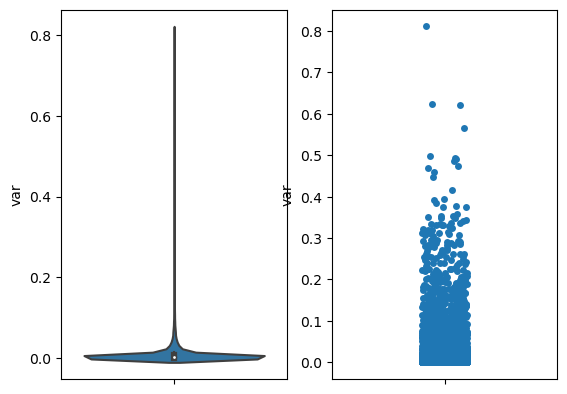

In [11]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(eqtl_group, y='var', ax= ax[0])
sns.stripplot(eqtl_group, y='var', ax= ax[1])

<Axes: ylabel='extreme_score'>

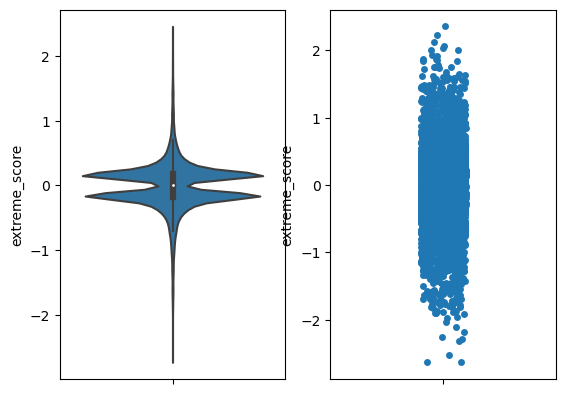

In [24]:
fig, ax = plt.subplots(1, 2)
sns.violinplot(eqtl_group, y='extreme_score', ax= ax[0])
sns.stripplot(eqtl_group, y='extreme_score', ax= ax[1])

In [5]:
eqtl_group_sorted = eqtl_group.sort_values('var', ascending=False)

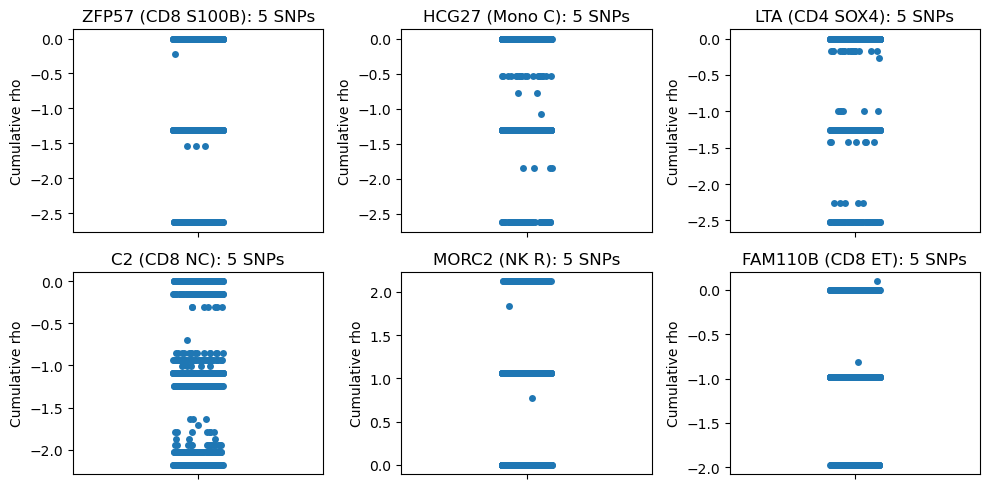

In [11]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(10, 5)
for i in range(6):
    sns.stripplot(eqtl_group_sorted.iloc[i, 4:-3], ax = ax.flatten()[i])
    ax.flatten()[i].set_title(
        f'{eqtl_group_sorted.iloc[i, 1]} ({eqtl_group_sorted.iloc[i, 2]}): {eqtl_group_sorted.iloc[i, -2]} SNPs'
                             )
    ax.flatten()[i].set_ylabel('Cumulative rho')
plt.tight_layout()

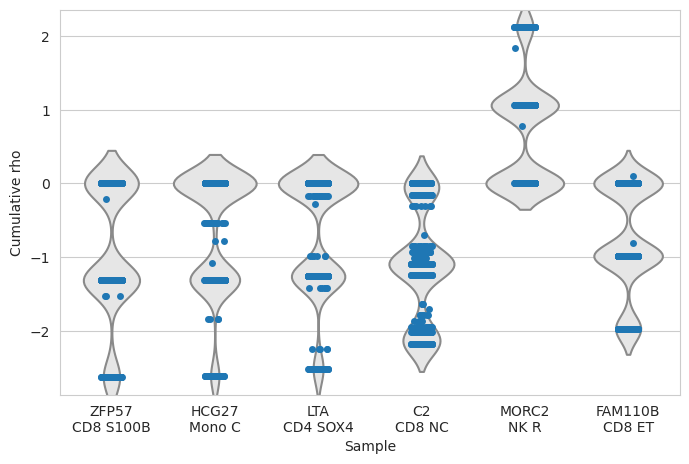

In [105]:
n_top = 6
# Prepare cumulative rho data for the plot
plot_df = eqtl_group_sorted.iloc[:n_top, 4:-3]
plot_df['Sample'] = eqtl_group_sorted.iloc[:n_top, 1:3].agg('\n'.join, axis=1)
plot_df['Gene'] = eqtl_group_sorted.iloc[:n_top, 1]
plot_df = pd.melt(plot_df, id_vars=['Sample', 'Gene'], value_name='Cumulative rho')

plt.rcParams["figure.figsize"] = (8,5)
sns.set_style("whitegrid")
sns.violinplot(plot_df, x='Sample', y='Cumulative rho', color='.9', inner=None)
sns.stripplot(plot_df, x='Sample', y='Cumulative rho')
plt.savefig('figures/cumulative_rho_distribution.png', dpi=300)

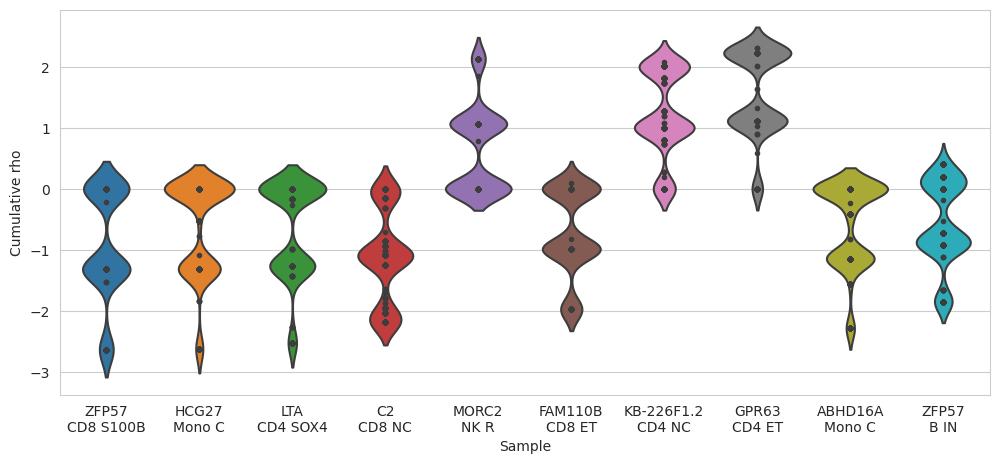

In [92]:
n_top = 10
# Prepare cumulative rho data for the plot
plot_df = eqtl_group_sorted.iloc[:n_top, 4:-3]
plot_df['Sample'] = eqtl_group_sorted.iloc[:n_top, 1:3].agg('\n'.join, axis=1)
plot_df['Gene'] = eqtl_group_sorted.iloc[:n_top, 1]
plot_df = pd.melt(plot_df, id_vars=['Sample', 'Gene'], value_name='Cumulative rho')

plt.rcParams["figure.figsize"] = (12,5)
sns.set_style("whitegrid")
sns.violinplot(plot_df, x='Sample', y='Cumulative rho', inner='point')
plt.savefig('figures/cumulative_rho_distribution_violin.png', dpi=300)

## Expression averaged by patient

In [2]:
data = ad.read_h5ad('/home/e860a/chernova/my_onek1k_data/onek1k.norm_pflofpf.h5ad')

In [101]:
def cdf(x, label, ax, plot=True, *args, **kwargs):
    x, y = np.sort(x), np.arange(x.shape[0])/x.shape[0]
    if plot:
        # return sn.lineplot(pd.DataFrame({'Expression':x, 'Percentage':y}),
        #                    x='Percentage', y='Expression', *args, **kwargs)
        ax.plot(x, y, ':', label=label, *args, **kwargs)
    else:
        return x, y   

#### Just ZFP57

B IN
B Mem
CD4 ET
CD4 NC
CD8 ET
CD8 NC
CD8 S100B
NK


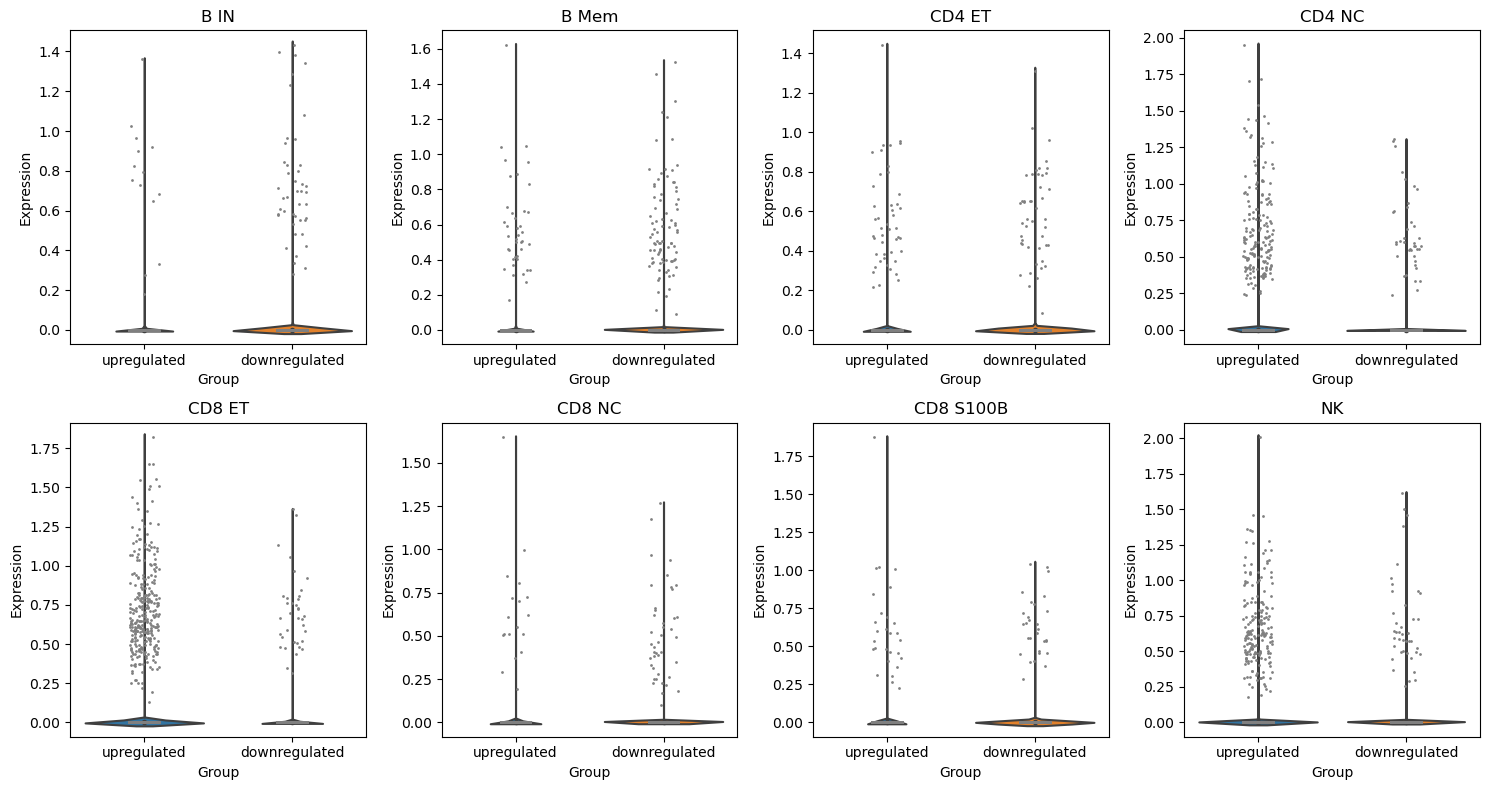

In [23]:
gene_name = 'ZFP57'
gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
data_gene = data[:, gene_id]
patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
patient_counts.columns = patient_counts.iloc[0, :]
patient_counts = patient_counts.drop(index=['Cell type', 'all_snp']).reset_index()

cell_types = patient_counts.columns[1:]

fig, ax = plt.subplots(2, 4)
fig.set_size_inches(15, 8)
for i, cell_type in enumerate(cell_types):
    
    print(cell_type)
    
    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']
    
    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]
    
    expression = []
    group_list = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression.append(x.flatten())
        group_list.extend([group for i in range(x.shape[0])])
    df = pd.DataFrame({'Expression': np.concatenate(expression),
                       'Group': group_list})
    sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i])
    sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i], size=2, color='grey')
    ax.flatten()[i].set_title(cell_type)
plt.tight_layout()

B IN
B Mem
CD4 ET
CD4 NC
CD8 ET
CD8 NC
CD8 S100B
NK


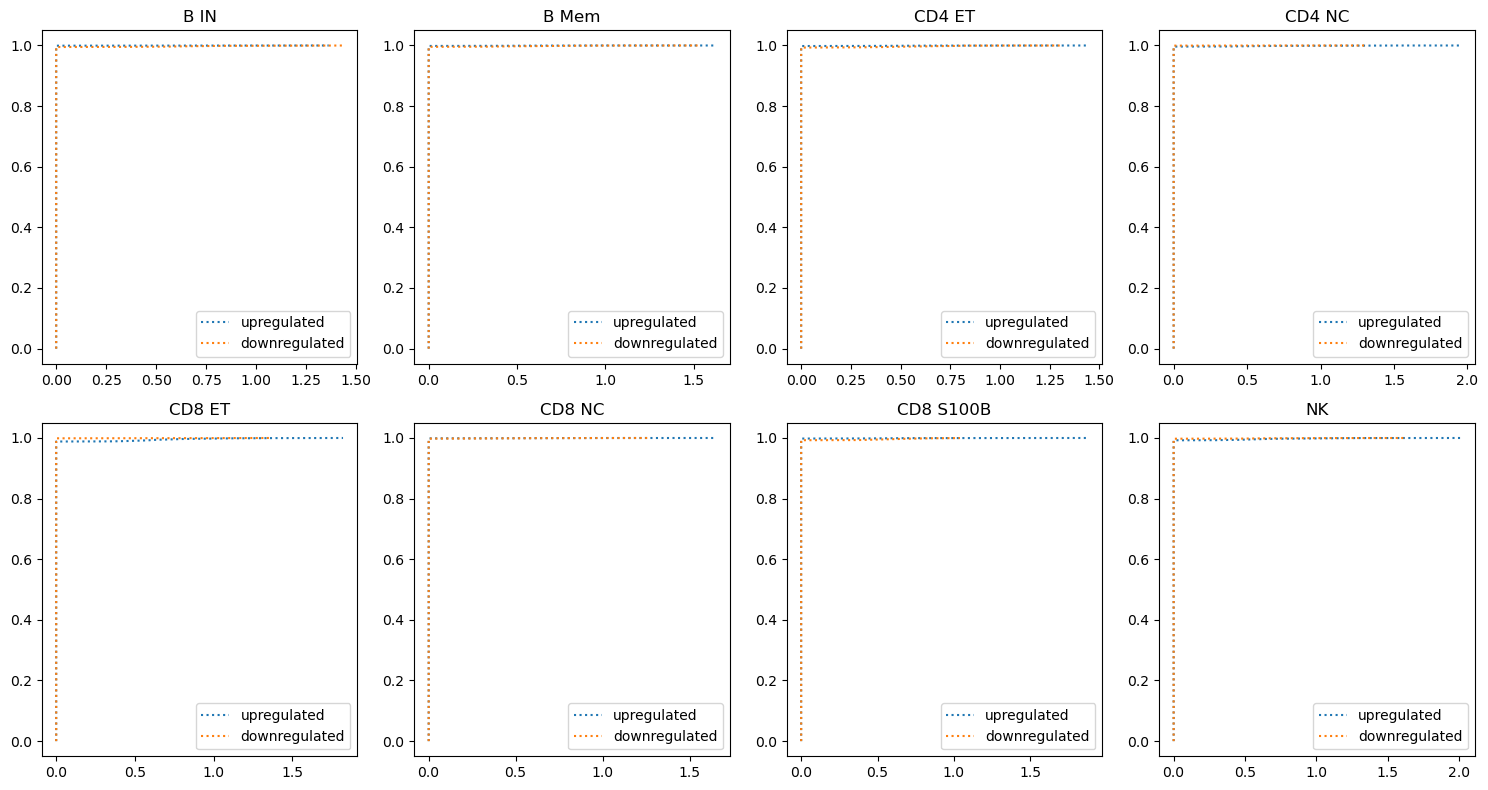

In [26]:
gene_name = 'ZFP57'
gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
data_gene = data[:, gene_id]
patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
patient_counts.columns = patient_counts.iloc[0, :]
patient_counts = patient_counts.drop(index=['Cell type', 'all_snp']).reset_index()

cell_types = patient_counts.columns[1:]

fig, ax = plt.subplots(2, 4)
fig.set_size_inches(15, 8)
for i, cell_type in enumerate(cell_types):
    
    print(cell_type)
    
    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']
    
    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]
    
    expression = []
    groups = ['upregulated', 'downregulated']
    group_list = []
    for j, group in enumerate(groups):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression.append(x.flatten())
        group_list.extend([group for i in range(x.shape[0])])
    df = pd.DataFrame({'Expression': np.concatenate(expression),
                       'Group': group_list})
    for sample in range(len(expression)):
        cdf(expression[sample], groups[sample], ax=ax.flatten()[i])
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(cell_type)
plt.tight_layout()

### Sort by variance

In [94]:
eqtl_group_sorted = eqtl_group.sort_values('var', ascending=False)
eqtl_group_sorted.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1083_1084,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score,n_snp,var
13587,ENSG00000204644,ZFP57,CD8 S100B,"rs739780,rs1737028,rs1610634,rs1362068,rs1362070",-1.3160,-1.3160,0.0000,0.0000,-1.3160,-1.316,...,0.0000,0.0000,-1.3160,-1.3160,-1.316,0.000,0.0000,-2.632,5,0.810791
13705,ENSG00000206344,HCG27,Mono C,"rs9380159,rs9357094,rs17194607,rs2517607,rs251...",-1.3105,-1.3105,-1.3105,0.0000,0.0000,0.000,...,0.0000,-1.3105,0.0000,0.0000,0.000,-2.621,-1.3105,-2.621,5,0.622899
14279,ENSG00000226979,LTA,CD4 SOX4,"rs3130976,rs3095298,rs3094220,rs3094216,rs3095300",0.0000,-2.5270,-1.4280,0.0000,-1.2635,0.000,...,-0.1645,-1.2635,0.0000,-1.2635,0.000,0.000,-1.2635,-2.527,5,0.619846
9258,ENSG00000166278,C2,CD8 NC,"rs7452226,rs2517536,rs2844645,rs2523867,rs3131926",-1.0905,-2.1810,-2.1810,-0.1545,-1.0905,-2.181,...,-1.0905,-1.0905,-0.1545,-1.0905,-2.181,0.000,-1.0905,-2.181,5,0.564756
5354,ENSG00000133422,MORC2,NK R,"rs2858750,rs8141011,rs2853884,rs2858752,rs1049583",0.0000,0.0000,1.0630,2.1260,0.0000,0.000,...,1.0630,0.0000,1.0630,2.1260,1.063,1.063,0.0000,2.126,5,0.496999


Genes/celltypes with highest variance

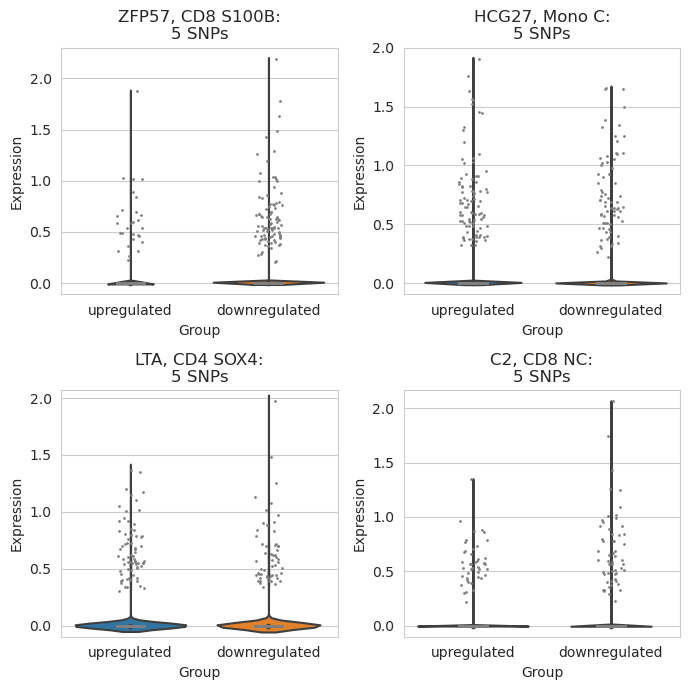

In [99]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    gene_name = eqtl_group_sorted.iloc[i, 1]
    n_snp = eqtl_group_sorted.iloc[i, -2]
    cell_type = eqtl_group_sorted.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.7)
    threshold_down = patient_counts[cell_type].quantile(0.3)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']

    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression.append(x.flatten())
        group_list.extend([group for i in range(x.shape[0])])
    df = pd.DataFrame({'Expression': np.concatenate(expression),
                       'Group': group_list})
    sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i])
    sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i], size=2, color='grey')
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{n_snp} SNPs')
plt.tight_layout()
plt.savefig('./figures/cumulative_highvar_30percent_allcells.png', dpi = 300)

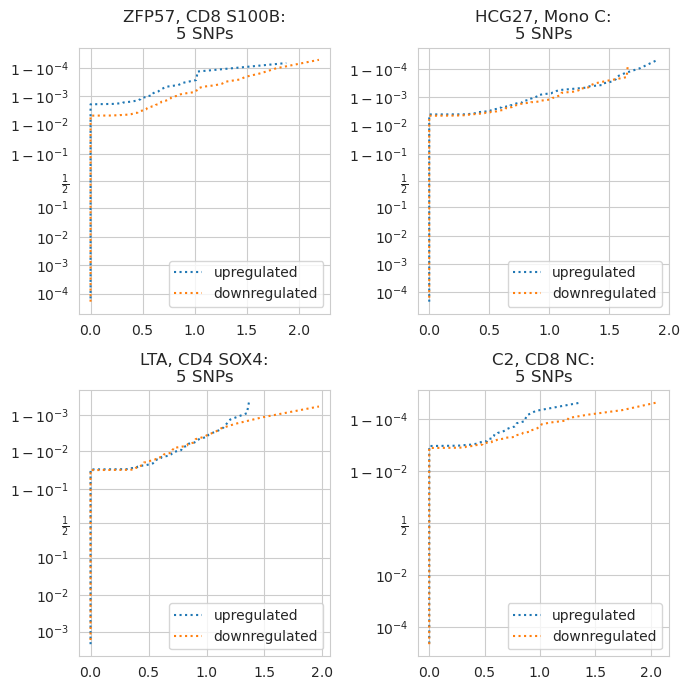

In [103]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    gene_name = eqtl_group_sorted.iloc[i, 1]
    n_snp = eqtl_group_sorted.iloc[i, -2]
    cell_type = eqtl_group_sorted.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.7)
    threshold_down = patient_counts[cell_type].quantile(0.3)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']

    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression = x.flatten()
        cdf(expression, group, ax=ax.flatten()[i])
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{n_snp} SNPs')
    ax.flatten()[i].set_yscale('logit')
plt.tight_layout()
plt.savefig('./figures/cumulative_highvar_30percent_allcells_cdf.png', dpi = 300)

### Genes/celltypes with most extreme effect sizes

In [107]:
eqtl_group['extreme_score_abs'] = eqtl_group['extreme_score'].abs()

In [108]:
eqtl_group_sort_extreme = eqtl_group.sort_values('extreme_score_abs', ascending=False)
eqtl_group_sort_extreme.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score,n_snp,var,extreme_score_abs
13587,ENSG00000204644,ZFP57,CD8 S100B,"rs739780,rs1737028,rs1610634,rs1362068,rs1362070",-1.3160,-1.3160,0.0000,0.0,-1.3160,-1.316,...,0.0000,-1.316,-1.3160,-1.316,0.000,0.0000,-2.632,5,0.810791,2.632
13705,ENSG00000206344,HCG27,Mono C,"rs9380159,rs9357094,rs17194607,rs2517607,rs251...",-1.3105,-1.3105,-1.3105,0.0,0.0000,0.000,...,-1.3105,0.000,0.0000,0.000,-2.621,-1.3105,-2.621,5,0.622899,2.621
14279,ENSG00000226979,LTA,CD4 SOX4,"rs3130976,rs3095298,rs3094220,rs3094216,rs3095300",0.0000,-2.5270,-1.4280,0.0,-1.2635,0.000,...,-1.2635,0.000,-1.2635,0.000,0.000,-1.2635,-2.527,5,0.619846,2.527
9259,ENSG00000166278,C2,NK,"rs3132541,rs3130562,rs7750641,rs2233980,rs3094222",0.0000,1.1770,0.0000,0.0,1.1770,0.000,...,0.0000,0.000,1.1770,0.000,0.000,0.0000,2.354,5,0.352224,2.354
12930,ENSG00000198339,HIST1H4I,CD8 ET,"rs67662114,rs13216117,rs36101351,rs28360499,rs...",0.0000,-1.1560,0.0000,0.0,-1.1560,0.000,...,0.0000,0.000,-1.1560,0.000,0.000,0.0000,-2.312,5,0.238726,2.312


In [110]:
sns.reset_orig()

#### Top/bottom 30%

In [112]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    gene_name = eqtl_group_sort_extreme.iloc[i, 1]
    n_snp = eqtl_group_sort_extreme.iloc[i, -3]
    cell_type = eqtl_group_sort_extreme.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']

    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression.append(x.flatten())
        group_list.extend([group for i in range(x.shape[0])])
    df = pd.DataFrame({'Expression': np.concatenate(expression),
                       'Group': group_list})
    sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i])
    sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i], size=2, color='grey')
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{n_snp} SNPs')
plt.tight_layout()
plt.savefig('./figures/cumulative_extreme_10percent_allcells.png', dpi = 300)

In [114]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    gene_name = eqtl_group_sort_extreme.iloc[i, 1]
    snp = eqtl_group_sort_extreme.iloc[i, 3]
    cell_type = eqtl_group_sort_extreme.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']

    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression = x.flatten()
        cdf(expression, group, ax=ax.flatten()[i])
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{n_snp} SNPs')
    #ax.flatten()[i].set_yscale('logit')
plt.tight_layout()
plt.savefig('./figures/cumulative_extreme_10percent_allcells_cdf_nonlogit.png', dpi = 300)

#### The most extreme rho values

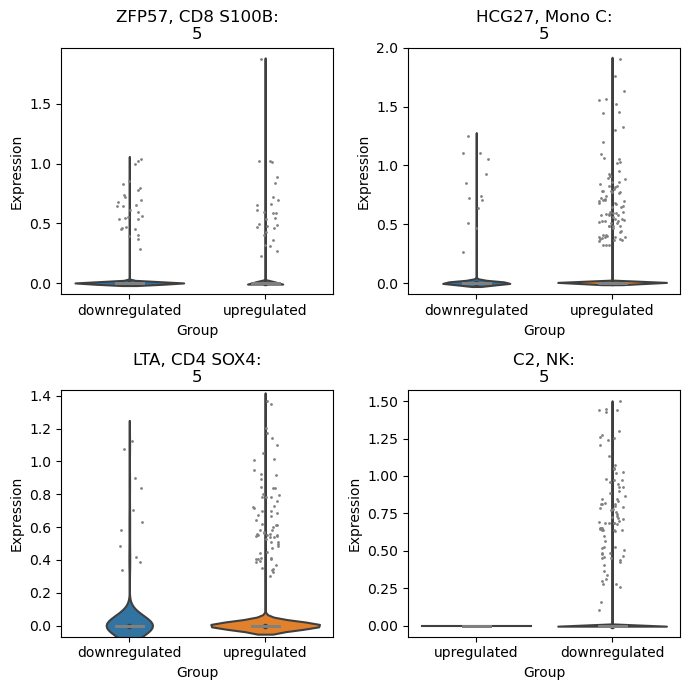

In [14]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    gene_name = eqtl_group_sort_extreme.iloc[i, 1]
    n_snp = eqtl_group_sort_extreme.iloc[i, -3]
    cell_type = eqtl_group_sort_extreme.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    extreme_score = patient_counts.loc['extreme_score', cell_type]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    # threshold_up = patient_counts[cell_type].quantile(0.7)
    # threshold_down = patient_counts[cell_type].quantile(0.3)
    if extreme_score >= 0:
        patients_up = patient_counts[patient_counts[cell_type] >= extreme_score].loc[:, 'index']
    else:
        patients_up = patient_counts[patient_counts[cell_type] <= extreme_score].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] == 0].loc[:, 'index']
    
    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]
    
    expression = []
    group_list = []
    if extreme_score>=0:
        name_list = ['upregulated', 'downregulated']
    else:
        name_list = ['downregulated', 'upregulated']
        
    for j, group in enumerate(name_list):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression.append(x.flatten())
        group_list.extend([group for i in range(x.shape[0])])
    df = pd.DataFrame({'Expression': np.concatenate(expression),
                       'Group': group_list})
    sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i])
    sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i], size=2, color='grey')
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{n_snp}')
plt.tight_layout()
plt.savefig('./figures/cumulative_extreme_mostextreme_allcells.png', dpi = 300)

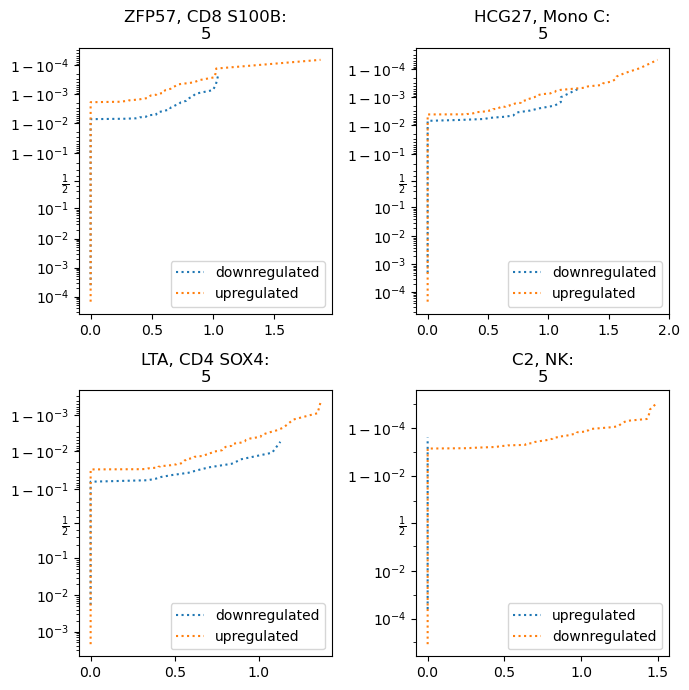

In [15]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    gene_name = eqtl_group_sort_extreme.iloc[i, 1]
    n_snp = eqtl_group_sort_extreme.iloc[i, -3]
    cell_type = eqtl_group_sort_extreme.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    extreme_score = patient_counts.loc['extreme_score', cell_type]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    # threshold_up = patient_counts[cell_type].quantile(0.7)
    # threshold_down = patient_counts[cell_type].quantile(0.3)
    patients_up = patient_counts[patient_counts[cell_type] == extreme_score].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] == 0].loc[:, 'index']
    
    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]
    
    expression = []
    group_list = []
    if extreme_score>=0:
        name_list = ['upregulated', 'downregulated']
    else:
        name_list = ['downregulated', 'upregulated']
        
    for j, group in enumerate(name_list):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression = x.flatten()
        cdf(expression, group, ax=ax.flatten()[i])
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{n_snp}')
    ax.flatten()[i].set_yscale('logit')
plt.tight_layout()
plt.savefig('./figures/cumulative_extreme_mostextreme_allcells_cdf.png', dpi = 300)

#### Aggregate by patient

0


100%|██████████| 134/134 [00:01<00:00, 86.57it/s]


1


100%|██████████| 419/419 [00:05<00:00, 81.80it/s]


2


100%|██████████| 455/455 [00:05<00:00, 78.56it/s]


3


100%|██████████| 756/756 [00:11<00:00, 63.90it/s]


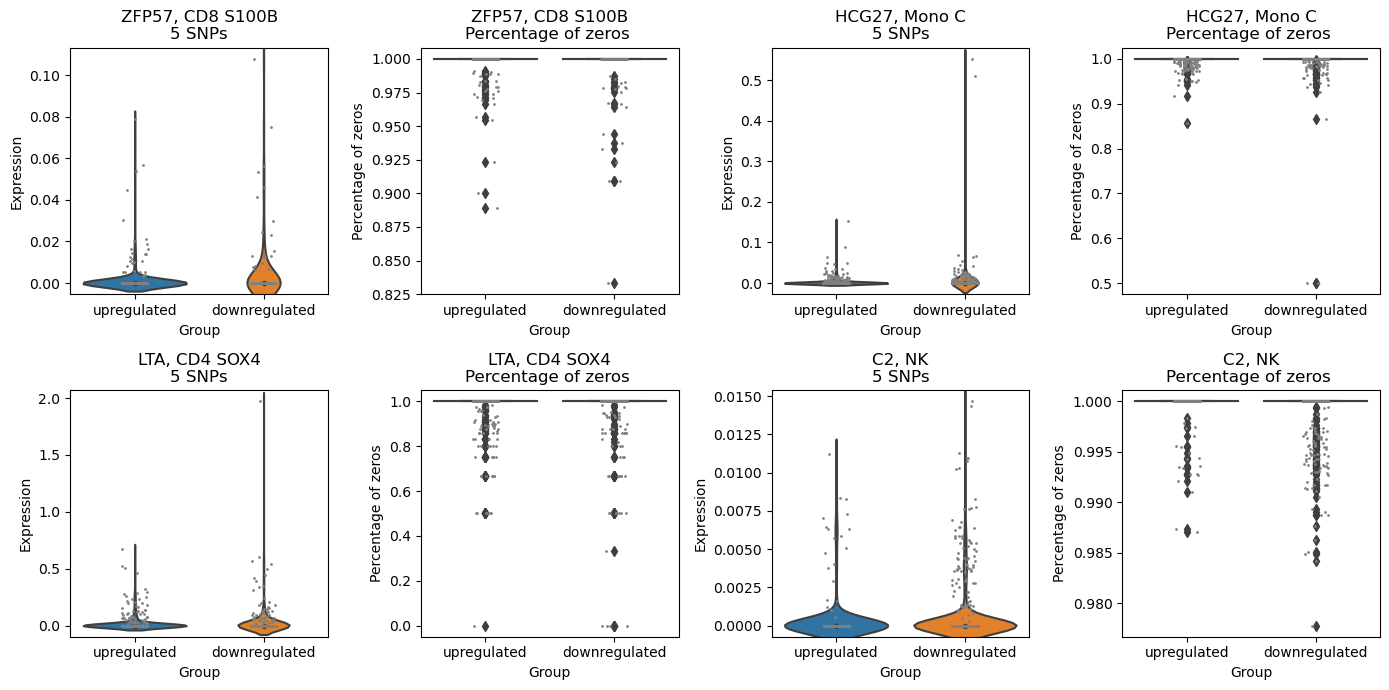

In [27]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(14, 7)
for i in range(4):
    print(i)
    gene_name = eqtl_group_sort_extreme.iloc[i, 1]
    n_snp = eqtl_group_sort_extreme.iloc[i, -3]
    cell_type = eqtl_group_sort_extreme.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']
    
    patient_list = [patients_up, patients_down]

    # search_str_up = '$|^'.join(patients_up.tolist())
    # search_str_up = '^'+search_str_up + '$'
    # mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    # search_str_down = '$|^'.join(patients_down.tolist())
    # search_str_down = '^'+search_str_down + '$'
    # mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    # mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    zero_percentage = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        patients = patient_list[j]
        for pat in tqdm(patients):
            mask_final = np.logical_and(data_gene.obs.individual.str.contains(pat), 
                                        data.obs.old_cell_label==cell_type)
            x = data[mask_final, gene_id]
            if x.shape[0] > 0:
                expression.append(x.X.mean())
                group_list.append(group)
                zero_percentage.append(np.sum(x.to_df().to_numpy()==0)/x.X.shape[0])
    df = pd.DataFrame({'Expression': expression,
                       'Group': group_list})
    df_zeros = pd.DataFrame({'Percentage of zeros': zero_percentage,
                               'Group': group_list})
    sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i*2])
    sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i*2], size=2, color='grey')
    ax.flatten()[i*2].set_title(f'{gene_name}, {cell_type}\n{n_snp} SNPs')
    
    sns.boxplot(df_zeros, x='Group', y='Percentage of zeros', ax=ax.flatten()[i*2+1])
    sns.stripplot(df_zeros, x='Group', y='Percentage of zeros', ax=ax.flatten()[i*2+1], size=2, color='grey')
    ax.flatten()[i*2+1].set_title(f'{gene_name}, {cell_type}\nPercentage of zeros')
plt.tight_layout()
plt.savefig('./figures/cumulative_extreme_10percent_aggregpatient.png', dpi = 300)

0


100%|██████████| 134/134 [00:02<00:00, 63.60it/s]


1


100%|██████████| 419/419 [00:05<00:00, 70.42it/s]


2


100%|██████████| 455/455 [00:05<00:00, 79.08it/s]


3


100%|██████████| 756/756 [00:11<00:00, 65.28it/s]


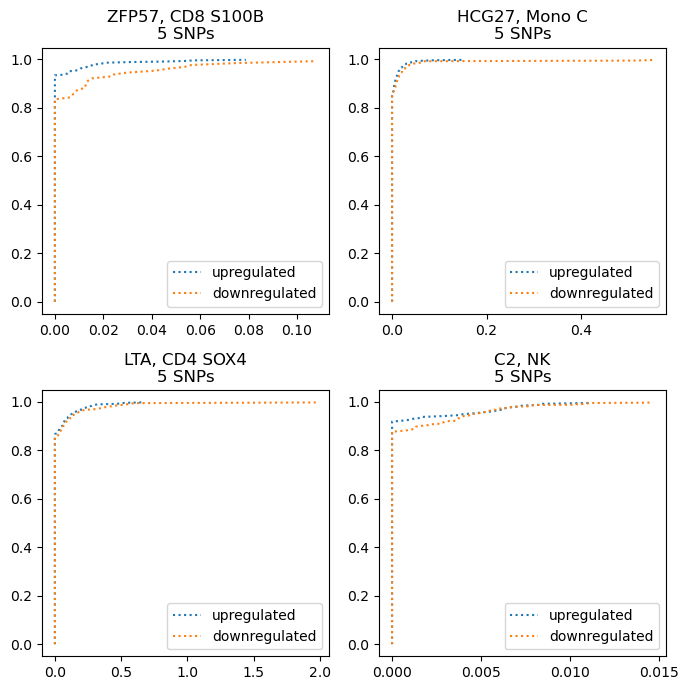

In [30]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(7, 7)
for i in range(4):
    print(i)
    gene_name = eqtl_group_sort_extreme.iloc[i, 1]
    n_snp = eqtl_group_sort_extreme.iloc[i, -3]
    cell_type = eqtl_group_sort_extreme.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']
    
    patient_list = [patients_up, patients_down]

    # search_str_up = '$|^'.join(patients_up.tolist())
    # search_str_up = '^'+search_str_up + '$'
    # mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    # search_str_down = '$|^'.join(patients_down.tolist())
    # search_str_down = '^'+search_str_down + '$'
    # mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    # mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    zero_percentage = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        patients = patient_list[j]
        for pat in tqdm(patients):
            mask_final = np.logical_and(data_gene.obs.individual.str.contains(pat), 
                                        data.obs.old_cell_label==cell_type)
            x = data[mask_final, gene_id]
            if x.shape[0] > 0:
                expression.append(x.X.mean())
                group_list.append(group)
                zero_percentage.append(np.sum(x.to_df().to_numpy()==0)/x.X.shape[0])
    df = pd.DataFrame({'Expression': expression,
                       'Group': group_list})
    df_zeros = pd.DataFrame({'Percentage zero': zero_percentage,
                               'Group': group_list})
    
    for group in ['upregulated', 'downregulated']:
        cdf(np.array(expression)[np.array(group_list)==group], group, ax=ax.flatten()[i])
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}\n{n_snp} SNPs')
plt.tight_layout()
plt.savefig('./figures/cumulative_extreme_10percent_aggregpatient_cdf.png', dpi = 300)

### Sort by most non-zero values and highest effect size

In [4]:
eqtl_group['extreme_score_abs'] = eqtl_group['extreme_score'].abs()
eqtl_group_sort_extreme = eqtl_group.sort_values('extreme_score_abs', ascending=False)
eqtl_group_sort_extreme.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1084_1085,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score,n_snp,var,extreme_score_abs
13587,ENSG00000204644,ZFP57,CD8 S100B,"rs739780,rs1737028,rs1610634,rs1362068,rs1362070",-1.3160,-1.3160,0.0000,0.0,-1.3160,-1.316,...,0.0000,-1.316,-1.3160,-1.316,0.000,0.0000,-2.632,5,0.810791,2.632
13705,ENSG00000206344,HCG27,Mono C,"rs9380159,rs9357094,rs17194607,rs2517607,rs251...",-1.3105,-1.3105,-1.3105,0.0,0.0000,0.000,...,-1.3105,0.000,0.0000,0.000,-2.621,-1.3105,-2.621,5,0.622899,2.621
14279,ENSG00000226979,LTA,CD4 SOX4,"rs3130976,rs3095298,rs3094220,rs3094216,rs3095300",0.0000,-2.5270,-1.4280,0.0,-1.2635,0.000,...,-1.2635,0.000,-1.2635,0.000,0.000,-1.2635,-2.527,5,0.619846,2.527
9259,ENSG00000166278,C2,NK,"rs3132541,rs3130562,rs7750641,rs2233980,rs3094222",0.0000,1.1770,0.0000,0.0,1.1770,0.000,...,0.0000,0.000,1.1770,0.000,0.000,0.0000,2.354,5,0.352224,2.354
12930,ENSG00000198339,HIST1H4I,CD8 ET,"rs67662114,rs13216117,rs36101351,rs28360499,rs...",0.0000,-1.1560,0.0000,0.0,-1.1560,0.000,...,0.0000,0.000,-1.1560,0.000,0.000,0.0000,-2.312,5,0.238726,2.312


In [5]:
high_eff_genes = eqtl_group_sort_extreme.iloc[:100, 0].tolist()
eqtl_high_eff = eqtl_group_sort_extreme.iloc[:100, :]

In [8]:
nonzero = [csr_matrix.count_nonzero(data[:, gene].X) for gene in high_eff_genes]

In [13]:
eqtl_high_eff['n_non_zero'] = nonzero

/tmp/ipykernel_31511/2757328707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_high_eff['n_non_zero'] = nonzero


In [14]:
eqtl_high_eff.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score,n_snp,var,extreme_score_abs,n_non_zero
13587,ENSG00000204644,ZFP57,CD8 S100B,"rs739780,rs1737028,rs1610634,rs1362068,rs1362070",-1.3160,-1.3160,0.0000,0.0,-1.3160,-1.316,...,-1.316,-1.3160,-1.316,0.000,0.0000,-2.632,5,0.810791,2.632,4409
13705,ENSG00000206344,HCG27,Mono C,"rs9380159,rs9357094,rs17194607,rs2517607,rs251...",-1.3105,-1.3105,-1.3105,0.0,0.0000,0.000,...,0.000,0.0000,0.000,-2.621,-1.3105,-2.621,5,0.622899,2.621,4627
14279,ENSG00000226979,LTA,CD4 SOX4,"rs3130976,rs3095298,rs3094220,rs3094216,rs3095300",0.0000,-2.5270,-1.4280,0.0,-1.2635,0.000,...,0.000,-1.2635,0.000,0.000,-1.2635,-2.527,5,0.619846,2.527,29018
9259,ENSG00000166278,C2,NK,"rs3132541,rs3130562,rs7750641,rs2233980,rs3094222",0.0000,1.1770,0.0000,0.0,1.1770,0.000,...,0.000,1.1770,0.000,0.000,0.0000,2.354,5,0.352224,2.354,2543
12930,ENSG00000198339,HIST1H4I,CD8 ET,"rs67662114,rs13216117,rs36101351,rs28360499,rs...",0.0000,-1.1560,0.0000,0.0,-1.1560,0.000,...,0.000,-1.1560,0.000,0.000,0.0000,-2.312,5,0.238726,2.312,1046


In [15]:
eqtl_high_eff = eqtl_high_eff.sort_values('n_non_zero', ascending=False)
eqtl_high_eff.head()

,Gene Ensembl ID,Gene ID,Cell type,all_snp,1_1,2_2,3_3,4_4,6_6,7_7,...,1096_845_2,1100_914_2,1102_932_2,1103_926_2,1104_920_2,extreme_score,n_snp,var,extreme_score_abs,n_non_zero
13273,ENSG00000204257,HLA-DMA,CD4 SOX4,"rs9268632,rs9268641,rs3129872,rs3129873,rs3129874",0.0000,0.8055,0.0000,0.0000,1.611,0.000,...,0.8055,0.8055,0.000,0.0000,0.8055,1.611,5,0.275304,1.611,173220
14772,ENSG00000236016,RP1-3J17.3,CD8 NC,"rs12212560,rs6903114,rs2842603,rs9444346,rs945...",0.7890,0.7890,0.7890,0.7710,0.789,0.797,...,0.7890,0.7970,0.789,0.7710,0.7810,1.867,5,0.025186,1.867,54701
3137,ENSG00000111880,RNGTT,CD4 SOX4,"rs9359761,rs4519980,rs4485983,rs6925312,rs9294392",-1.5460,-0.7730,0.0000,-0.9765,0.000,-0.773,...,0.0000,-1.5460,-0.980,-1.5460,-1.5460,-1.546,5,0.291956,1.546,51528
13546,ENSG00000204599,TRIM39,DC,"rs2517614,rs3132565,rs2285801,rs3094639,rs1362089",-0.4595,-1.2555,-0.4595,-0.7960,-0.150,-0.946,...,-0.7960,-1.5920,-0.150,-0.9190,-1.2555,-1.592,5,0.187931,1.592,43247
13527,ENSG00000204576,PRR3,CD4 SOX4,"rs2524054,rs2524143,rs2524142,rs2524139,rs2853928",0.8865,0.8865,1.7730,0.8865,1.773,1.773,...,1.7730,0.8865,1.773,0.8865,1.7730,1.773,5,0.331907,1.773,40090


#### Top/bottom 10%

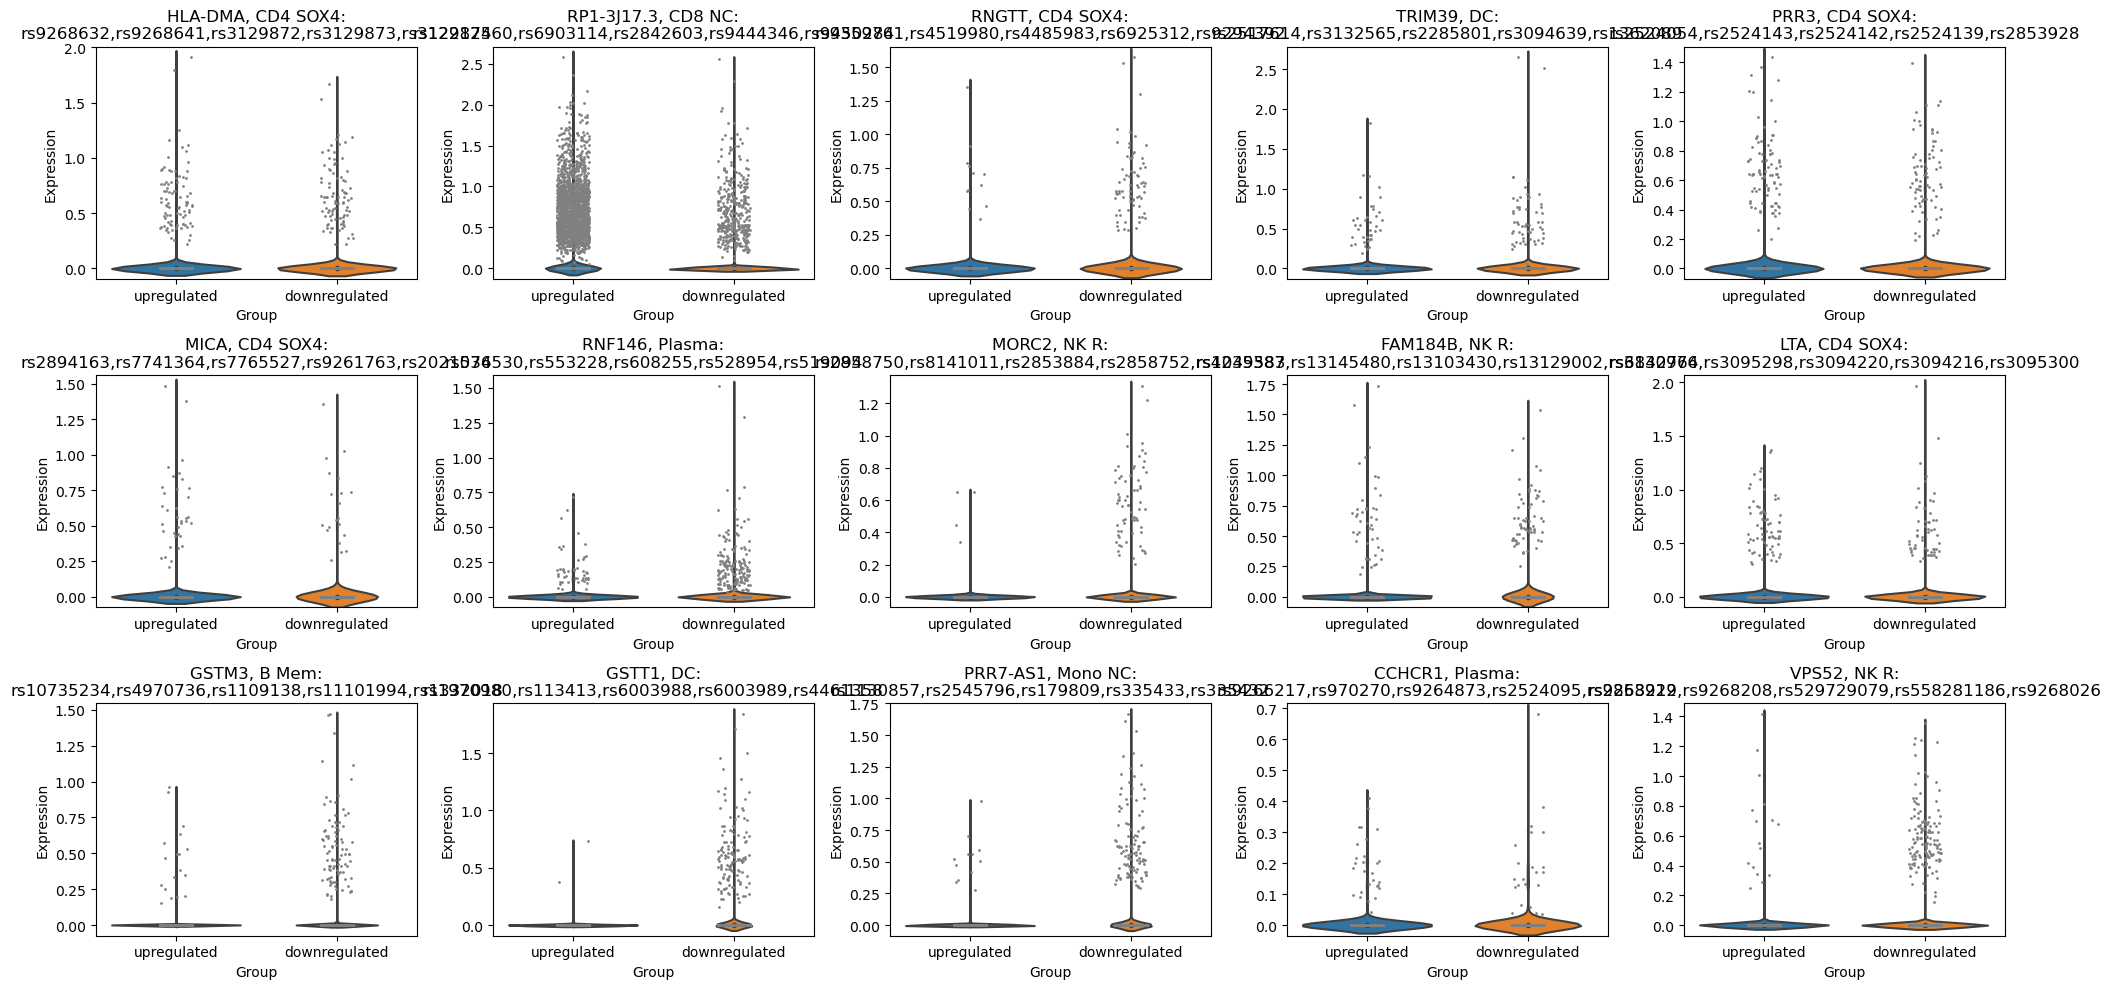

In [23]:
fig, ax = plt.subplots(3, 5)
fig.set_size_inches(20, 10)
for i in range(15):
    gene_name = eqtl_high_eff.iloc[i, 1]
    snp = eqtl_high_eff.iloc[i, 3]
    cell_type = eqtl_high_eff.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    threshold_up = patient_counts[cell_type].quantile(0.9)
    threshold_down = patient_counts[cell_type].quantile(0.1)
    patients_up = patient_counts[patient_counts[cell_type] >= threshold_up].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] <= threshold_down].loc[:, 'index']

    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]

    expression = []
    group_list = []
    for j, group in enumerate(['upregulated', 'downregulated']):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        expression.append(x.flatten())
        group_list.extend([group for i in range(x.shape[0])])
    df = pd.DataFrame({'Expression': np.concatenate(expression),
                       'Group': group_list})
    sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i])
    sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i], size=2, color='grey')
    ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{extreme_score}')
plt.tight_layout()

#### Most extreme rho values

RP1-3J17.3 CD8 NC empty
FAM184B NK R empty


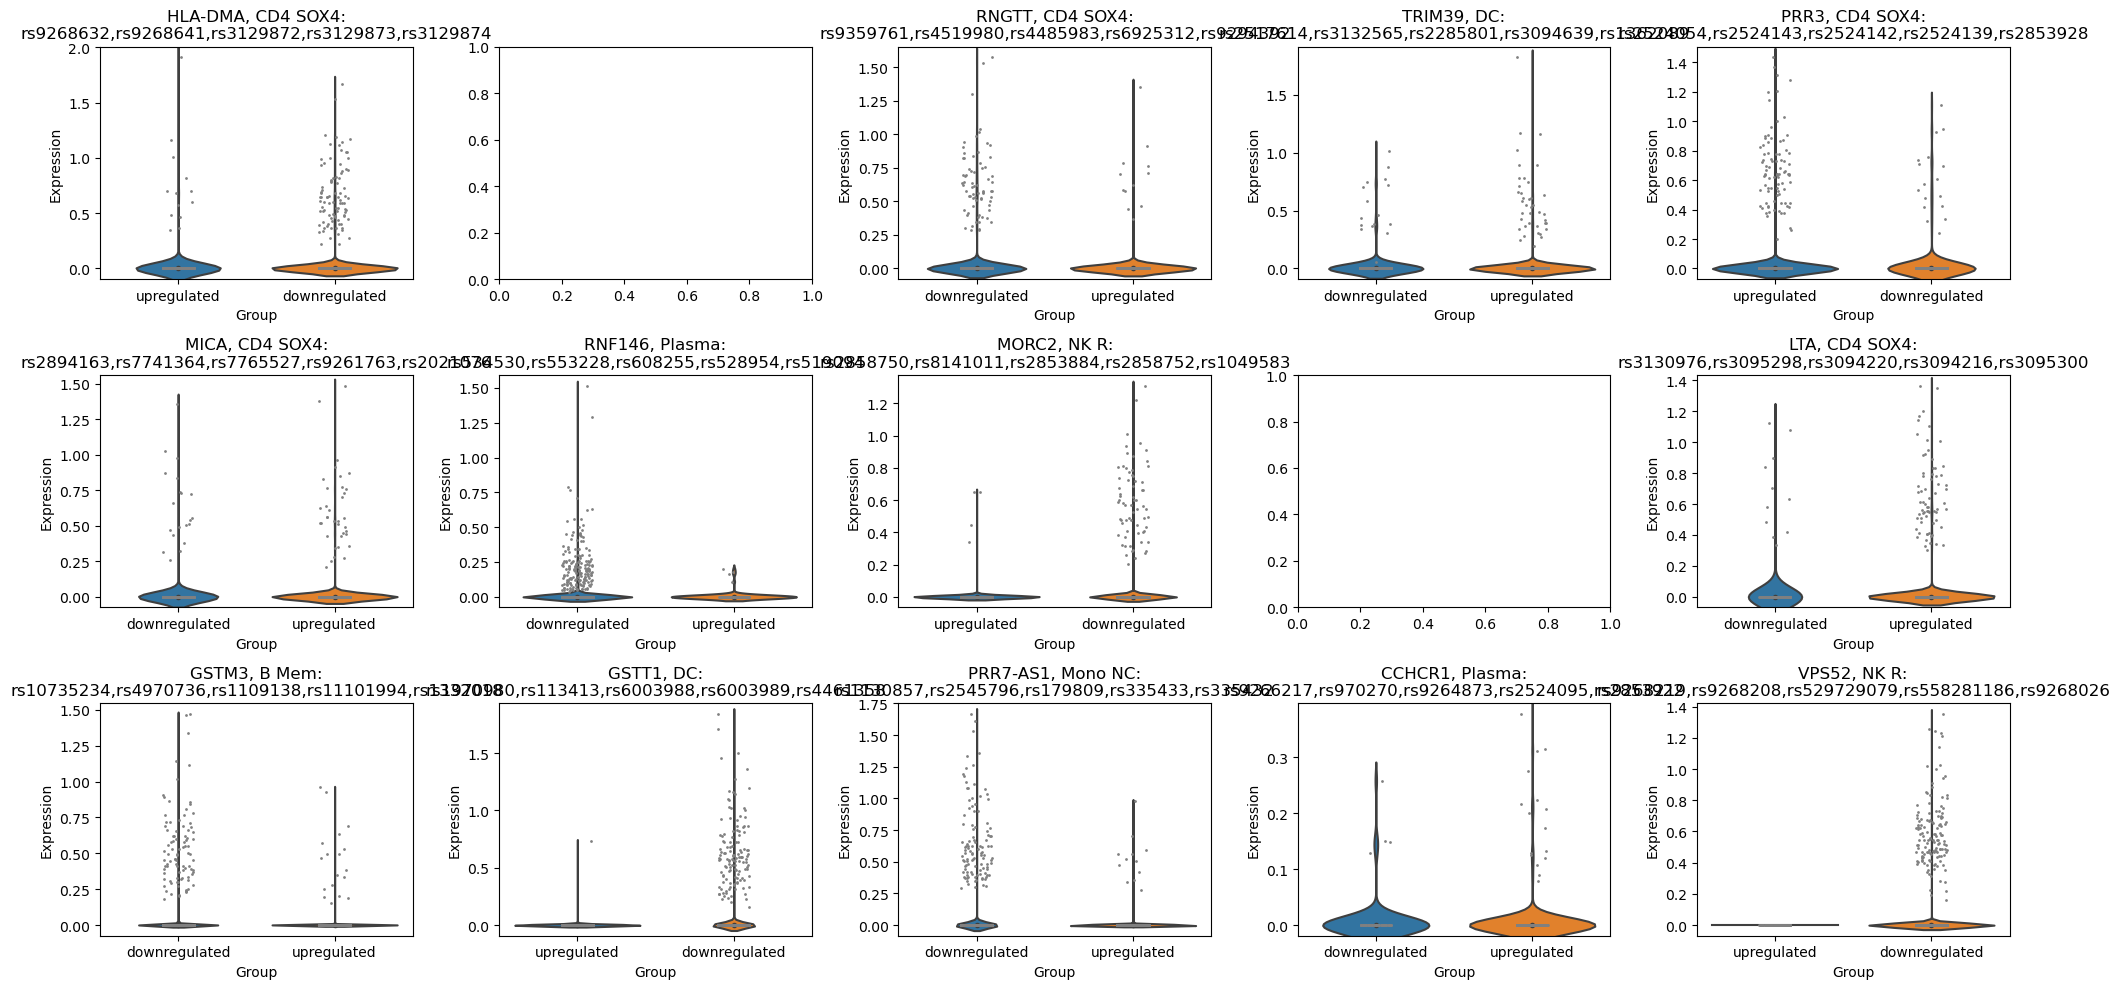

In [22]:
fig, ax = plt.subplots(3, 5)
fig.set_size_inches(20, 10)
for i in range(15):
    gene_name = eqtl_high_eff.iloc[i, 1]
    snp = eqtl_high_eff.iloc[i, 3]
    cell_type = eqtl_high_eff.iloc[i, 2]
    gene_id = eqtl_group[eqtl_group['Gene ID']==gene_name].iloc[0, 0]
    data_gene = data[:, gene_id]
    patient_counts = eqtl_group[eqtl_group['Gene Ensembl ID']==gene_id].iloc[:, 2:-1].T
    patient_counts.columns = patient_counts.iloc[0, :]
    extreme_score = patient_counts.loc['extreme_score', cell_type]
    patient_counts = patient_counts.drop(index=['Cell type', 'all_snp', 'extreme_score', 'n_snp', 'var']).reset_index()

    # threshold_up = patient_counts[cell_type].quantile(0.7)
    # threshold_down = patient_counts[cell_type].quantile(0.3)
    patients_up = patient_counts[patient_counts[cell_type] == extreme_score].loc[:, 'index']
    patients_down = patient_counts[patient_counts[cell_type] == 0].loc[:, 'index']
    
    search_str_up = '$|^'.join(patients_up.tolist())
    search_str_up = '^'+search_str_up + '$'
    mask_up = data_gene.obs.individual.str.contains(search_str_up, regex=True)
    search_str_down = '$|^'.join(patients_down.tolist())
    search_str_down = '^'+search_str_down + '$'
    mask_down = data_gene.obs.individual.str.contains(search_str_down, regex=True)
    mask_pat = [mask_up, mask_down]
    
    expression = []
    group_list = []
    if extreme_score>=0:
        name_list = ['upregulated', 'downregulated']
    else:
        name_list = ['downregulated', 'upregulated']
        
    for j, group in enumerate(name_list):
        mask_final = np.logical_and(mask_pat[j], data.obs.old_cell_label==cell_type)
        x = data[mask_final, gene_id].to_df().to_numpy()
        if x.shape[0] > 0:
            expression.append(x.flatten())
            group_list.extend([group for i in range(x.shape[0])])
    if len(expression) > 0:
        df = pd.DataFrame({'Expression': np.concatenate(expression),
                           'Group': group_list})
        sns.violinplot(df, x='Group', y='Expression', ax=ax.flatten()[i])
        sns.stripplot(df, x='Group', y='Expression', ax=ax.flatten()[i], size=2, color='grey')
        ax.flatten()[i].set_title(f'{gene_name}, {cell_type}:\n{snp}')
    else:
        print(gene_name, cell_type, 'empty')
plt.tight_layout()